## Imports

In [1]:
%matplotlib inline
import time
import math
import theano
import theano.tensor as T
import lasagne
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

from skimage import measure
from data import generate as generate_training_data
from network import setup as setup_network

def sample_box(img, x, y):
        box = np.zeros((1,1,box_size,box_size))
        margin = int(math.floor(box_size / 2))
        box[0:,0:,:]=img[x-margin:x+margin+1, y-margin:y+margin+1]
        return box

## Some hyperparameters

In [2]:
box_size = 29
num_epochs = 15
learning_rate = 0.00004
sample_radius = 2.5

## Generate training data and visualize

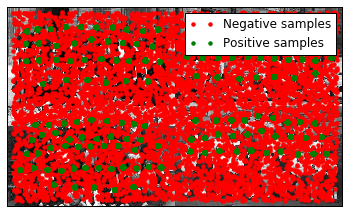

In [3]:
t_samples, t_labels, t_img = generate_training_data("train",
                                                box_size = box_size,
                                                sample_radius = sample_radius,
                                                enable_plotting = True)

## Generate validation data

In [4]:
v_samples, v_labels, v_img = generate_training_data("validation",
                                                box_size = box_size,
                                                sample_radius = sample_radius)

## Normalize data

In [5]:
t_mean = t_img.mean()
t_range = t_img.max()-t_img.min()

t_img = 2*(t_img-t_mean)/t_range
v_img = 2*(v_img-t_mean)/t_range

## Setup network

In [6]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
network = setup_network(input_var, box_size)

## Setup objective function

In [7]:
# Training
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var).mean()
train_acc = T.mean(T.eq(T.argmax(prediction, axis=1), target_var), dtype=theano.config.floatX)
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=learning_rate, momentum=0.9)
train_fn = theano.function([input_var, target_var], [loss, train_acc], updates=updates, allow_input_downcast=True)

# Validation
val_prediction = lasagne.layers.get_output(network, deterministic=True)
val_loss = lasagne.objectives.categorical_crossentropy(val_prediction, target_var).mean()
val_acc = T.mean(T.eq(T.argmax(val_prediction, axis=1), target_var), dtype=theano.config.floatX)
val_fn = theano.function([input_var, target_var], [val_loss, val_acc], allow_input_downcast=True)

ImportError: ('The following error happened while compiling the node', Dot22(Flatten{2}.0, W), '\n', 'dlopen(/Users/xiayuxuan/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/tmphAmm5u/15357f4a51bff61fa945bea566107bed.so, 2): Library not loaded: libmkl_intel_lp64.dylib\n  Referenced from: /Users/xiayuxuan/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/tmphAmm5u/15357f4a51bff61fa945bea566107bed.so\n  Reason: image not found', '[Dot22(<TensorType(float64, matrix)>, W)]')

## Optimize parameters

In [ ]:
for epoch in xrange(num_epochs):
    train_err = 0
    train_acc = 0
    val_err = 0
    val_acc = 0
    start_time = time.time()
    
    indices = np.arange(len(t_labels))
    np.random.shuffle(indices)

    for idx in range(0, len(t_labels)):
        ind = indices[idx]
        labels = np.zeros(1)
        labels[0] = t_labels[ind]
        err, acc = train_fn(sample_box(t_img, t_samples[ind][0], t_samples[ind][1]), labels)
        train_err += err
        train_acc += acc

    for idx in range(0, len(v_labels)):
        labels = np.zeros(1)
        labels[0] = v_labels[idx]
        err, acc = val_fn(sample_box(v_img, v_samples[idx][0], v_samples[idx][1]), labels)
        val_err += err
        val_acc += acc

    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t{:.6f}".format(train_err / len(t_labels)))
    print("  Training accuracy:\t{:.2f} %".format(train_acc / len(t_labels) * 100))
    print("  validation loss:\t{:.6f}".format(val_err / len(v_labels)))
    print("  validation accuracy:\t{:.2f} %".format(val_acc / len(v_labels) * 100))

## Sliding window

In [ ]:
eval_fn = theano.function([input_var], val_prediction)
output = np.zeros((v_img.shape[0], v_img.shape[1], 2))

margin = int(math.floor(box_size / 2))
for x in xrange(margin, int(v_img.shape[0] - margin)):
    for y in xrange(margin, int(v_img.shape[1] - margin)):
        patch = v_img[x-margin:x+margin+1, y-margin:y+margin+1]
        patch = patch.reshape(1,1, box_size, box_size)
        output[x,y,:] = eval_fn(patch)

## Detect local maxima

In [ ]:
# Smooth the output probabilities
heatmap = filters.gaussian_filter(output[:,:,1], 1) 
# Thresholding
seg = heatmap>0.5
# Non-maximum suppression
detections = np.where(np.multiply(seg, heatmap == filters.maximum_filter(heatmap, 20)))

## Plot detections

In [ ]:
fig, ax = plt.subplots()
ax.imshow(v_img, interpolation='nearest', cmap=plt.cm.gray)
plt.plot(detections[1], detections[0], 'b.', markersize=12, mew=3)
        
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
plt.rcParams['figure.figsize'] = 20,20